# Generalized Linear Models
Generalized Linear Models (GLMs) are - as the name suggests - a generalization of Linear Models. Linear Models (LMs) try to capture an assumed linear dependency between the independent variables (covariates) and the dependent variable. Thus, LMs are limited capture linear dependencies between covariates and the target variable. GLMs try to mitigate this issue by introducing so called link-function. If the link-function is a linear function (e.g. the identity mapping), we end up with a LM again. However, we can choose the link-function $g$ as an arbitrarily complex function. The most popular link-function is probably the logit function which is used to linear regression models capable of performing clsasification. Such models are known as logistic regression models.

Mathematically spoken, in linear models we predict the expected value of the target variable $y$ given input $\mathbf{x}$. Linear regression computes this value as follows:
\begin{equation}
\mathbb{E}[y | \mathbf{x}] = \mathbf{w}\mathbf{x}^T
\end{equation}

The job of the link function is now to "force" the linear model to predict the expected value under a transformation:
\begin{equation}
\sigma(\mathbb{E}[y | \mathbf{x}]) = \mathbf{w}\mathbf{x}^T
\end{equation}
Here, $\sigma$ is the link-function, e.g. the logit-function. Intuitively this formulation then wants our linear model to predict the expected value of $y$ under a logit-transformation. To get rid of the transformation, our model should instead apply the inverse transformation of $\sigma$ to its predictions, thus we end up with:
\begin{gather}
& \sigma^{-1}(\sigma(\mathbb{E}[y | \mathbf{x}])) = \sigma^{-1}(\mathbf{w}\mathbf{x}^T) \\
& \mathbb{E}[y | \mathbf{x}] = \sigma^{-1}(\mathbf{w}\mathbf{x}^T)
\end{gather}
In the case of $\sigma$ being the logit function, the inverse is the logistic function. This is known as the logistic regression.

In this notebook we will learn how to make use of GLMs to solve our problems known from before. We will learn how to:
- prepare data for GLMs
- select the correct link-function manually

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, r2_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [20]:
# load data
data = pd.read_csv('../data/climate-data/prepared_data.csv', index_col=0)

# extract labels
y = data['DailyMaximumDryBulbTemperature']
X = data.drop(columns=['DailyMaximumDryBulbTemperature'])

## Additional Preprocessing
Although we already did data cleaning, we have to do more preprocessing in order to use GLMs properly. To understand why we need to do further preprocessing, let's see what the assumptions of a simple linear regression are:
1. Linear relationship between independent variable(s) and dependent variable.
   This is obvious and simply means that we can describe the relationship between the independent variable(s) and the dependent variable with a linear function.
2. Identically, independently distributed data
   This means during collecting data, the distribution didn't change and that the samples are indepdendent of each other, i.e. knowing the value of sample $i$ doesn't tell us about sample $i+1$
3. No hidden missing variables
   We don't have unobserved variables that also have influence on our dependent variable.
4. Residuals are normally distributed (or: normal noise)
   Recall that the linear regression model assumes a relationship of the form $y = wx + \mathcal{N}(\mu, \sigma)$, that is we have normal noise added to the dependent variable. The reason why we assume this is that there might be a huge number of mechanisms influencing our $Y$ which are independent of $Y$ (e.g. measurement errors). Due to the Central Limit Theorem we know that the mean (you can think of this as the "mean of measurement errors") of our independent influences follows a normal distribution, regardless of how the distributions of the independent influences look like.
5. No/Little multicollinerarity
   There is no correlation between independent variables. This is needed to ensure that we are able to describe the influence of each $X$ on $Y$. Imagine we had two variables $X_1, X_2$ s.t. $X_2 = wX_1$ and we aim to fit a model $Y = w_1X_1 + w_2X_2 + N$ where $N$ is the noise. Then we wouldn't be able to safely tell the influence of $X_1$ and $X_2$ on $Y$. In such cases we often observe overfitting.
6. Homoscedasticity
   This simply states that the noise $N$ has a constant variance. In other words: Our model has a constant error across the samples. If this assumption is violated it is often a hint that we either have forgotten a feature or that we have a non-linear relationship between independent and dependent variable(s).
7. Indepdendent variable(s) are independent of error terms
   This assumption is not neceassarily needed because if it is violated it imidiately means that 6. is violated as well.
8. Error terms are not autoregressive
   This one isn't necessarily needed as well since if violated this would imply that either 6. or 4. or both are violated as well.

> **NOTE** There are no assumptions regarding the distribution of the independent and dependent variables, there is only the normality assumption of the residuals. However, a mismatch in distributions between independent and dependent variable(s) can indicate a non-linear relationship, that means we might have to transform some variables.

> **IMPORTANT!** The assumptions above only apply to the simple linear regreesion. For GLMs there might be additional assumptions that have to be met.

In the following we will do some further data analysis and apply further preprocessing if necessary and applicable.

Let's have a look on the distributions of each feature again:

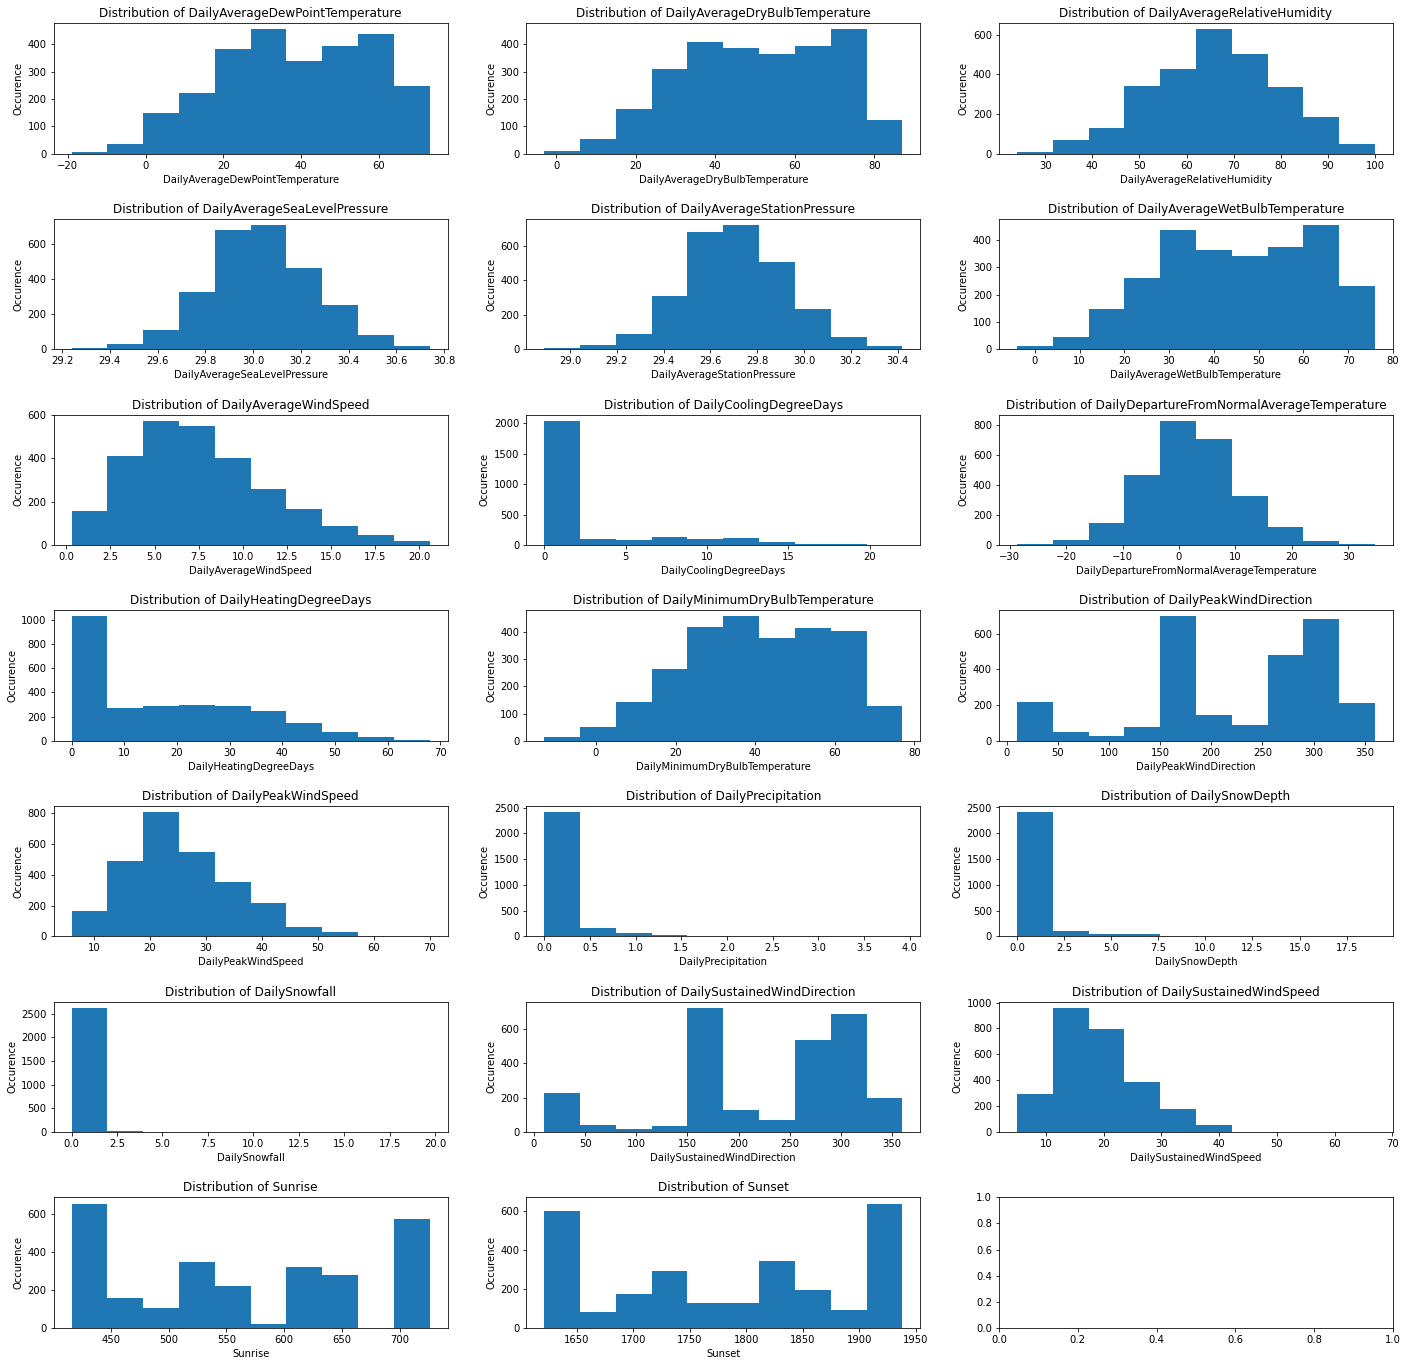

In [4]:
fig, axs = plt.subplots(7, 3, figsize=(24, 24))
for cidx, c in enumerate(X.columns):
    row_idx = cidx // 3
    col_idx = cidx % 3
    ax = axs[row_idx][col_idx]
    data = X[c]
    ax.hist(data)
    ax.set_title(f"Distribution of {c}")
    ax.set_xlabel(c)
    ax.set_ylabel('Occurence')
plt.subplots_adjust(hspace=0.5)
plt.show()

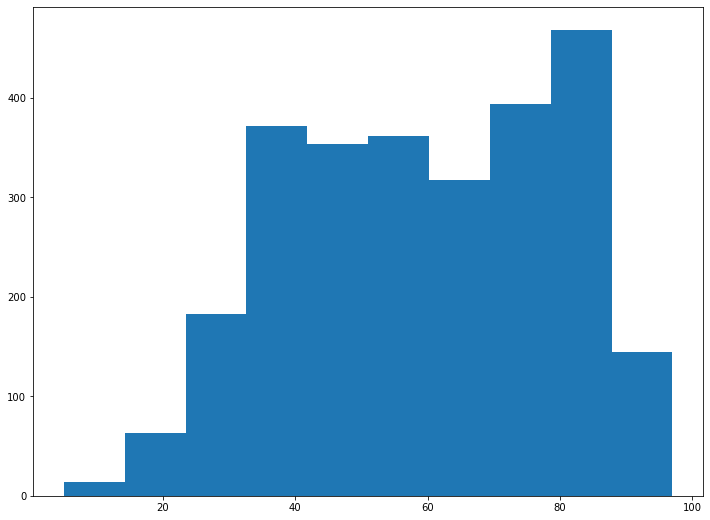

In [5]:
fig = plt.figure(figsize=(12, 9))
plt.hist(y)
plt.show()

Most features look as could we use them directly without transforming them to match a normal distribution. However, some of the feature seem to follow something different, looks like an exponential distribution or a very skewed normal distribution. Let's see the relationships between each feature and the dependent variable:

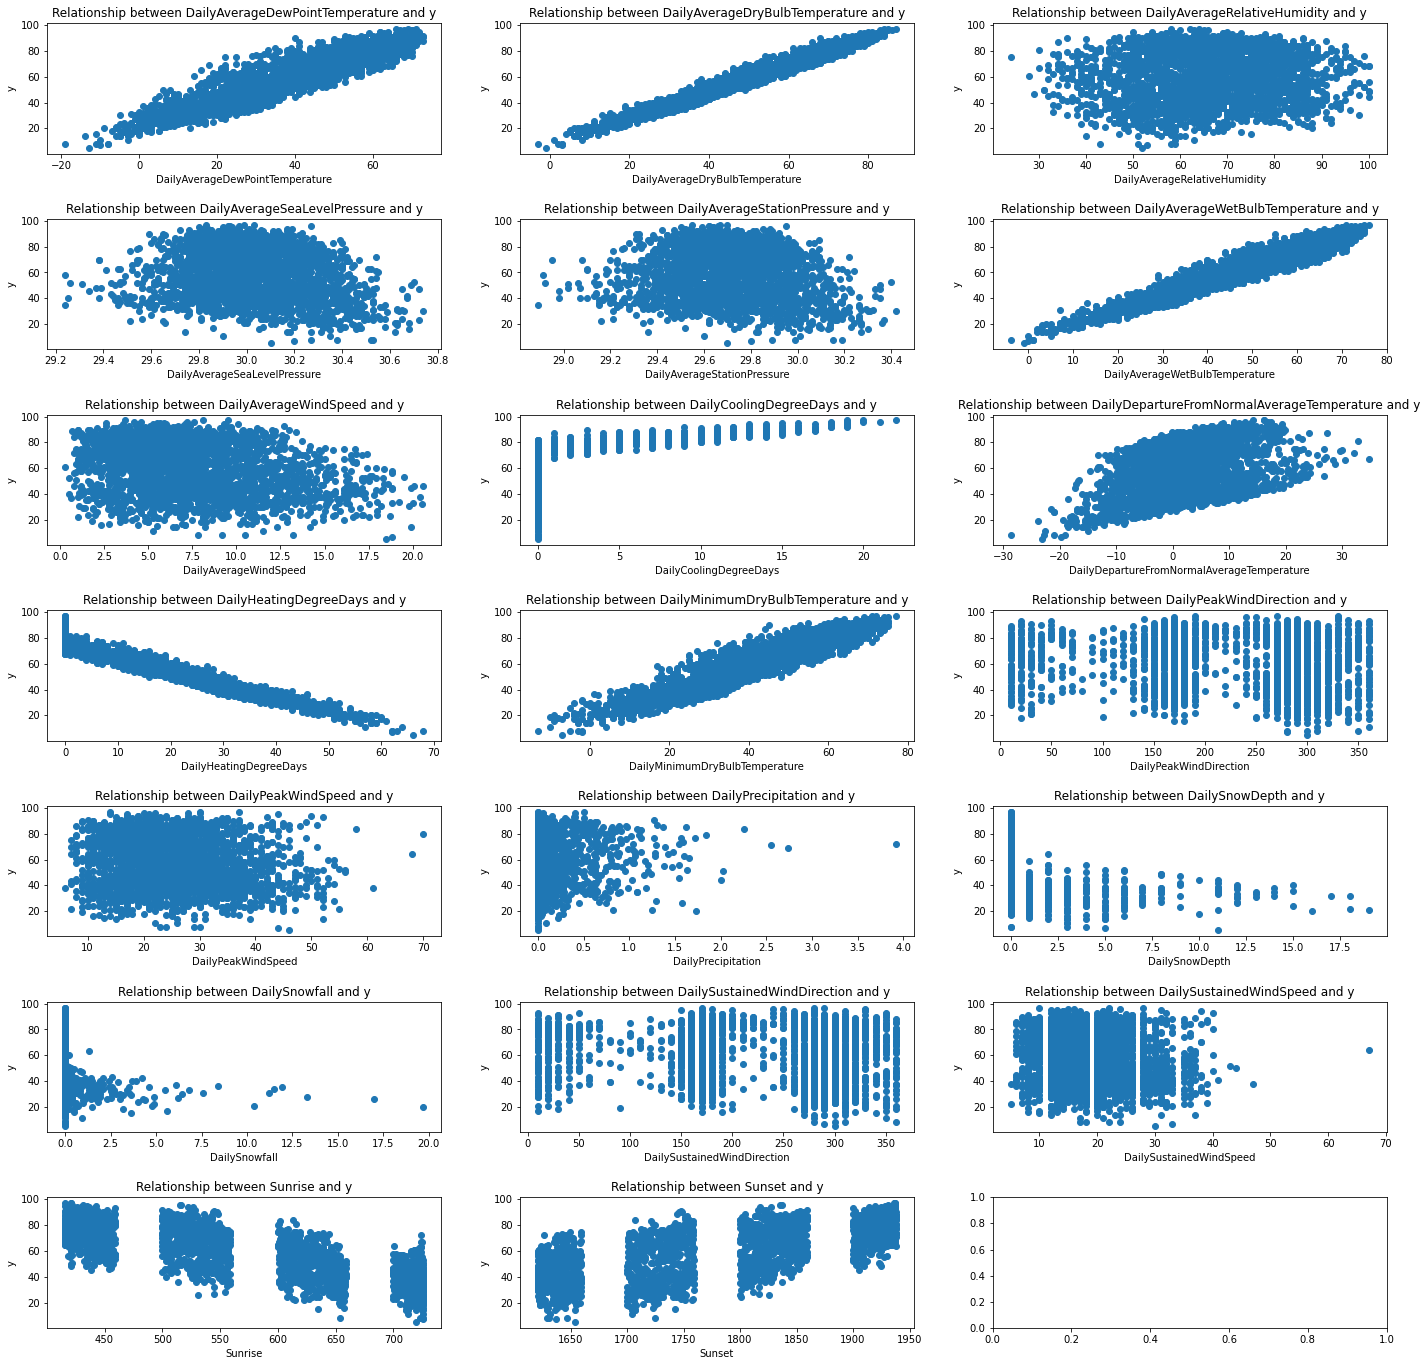

In [6]:
fig, axs = plt.subplots(7, 3, figsize=(24, 24))
for cidx, c in enumerate(X.columns):
    row_idx = cidx // 3
    col_idx = cidx % 3
    ax = axs[row_idx][col_idx]
    data = X[c]
    ax.scatter(data, y)
    ax.set_title(f"Relationship between {c} and y")
    ax.set_xlabel(c)
    ax.set_ylabel('y')
plt.subplots_adjust(hspace=0.5)
plt.show()

It's not surprisingly that we see that there are some non-linear relationships. All variables in $\mathbf{X}$ not following an approximate normal distribution seem to have a non-linear relationship to $\mathbf{y}$. Since $\mathbf{y}$ is approximately normal, this means that the linearity-assumption is violated for some features. Let's see if we can handle this by applying a $log$-transformation to these features:

In [7]:
features = ['DailySnowfall', 'DailySnowDepth', 'DailyPrecipitation']
for f in features:
    X.loc[:, f] = np.log(X[f] + 0.001) # add 0.001 to aovid log(0) = -inf

Note that we did not include `DailyHeatingDegreeDays` and `DailyCoolingDegreeDays` are not transformed since although they don't have a normal distribution, they seem still to have a linear relationship with $y$.

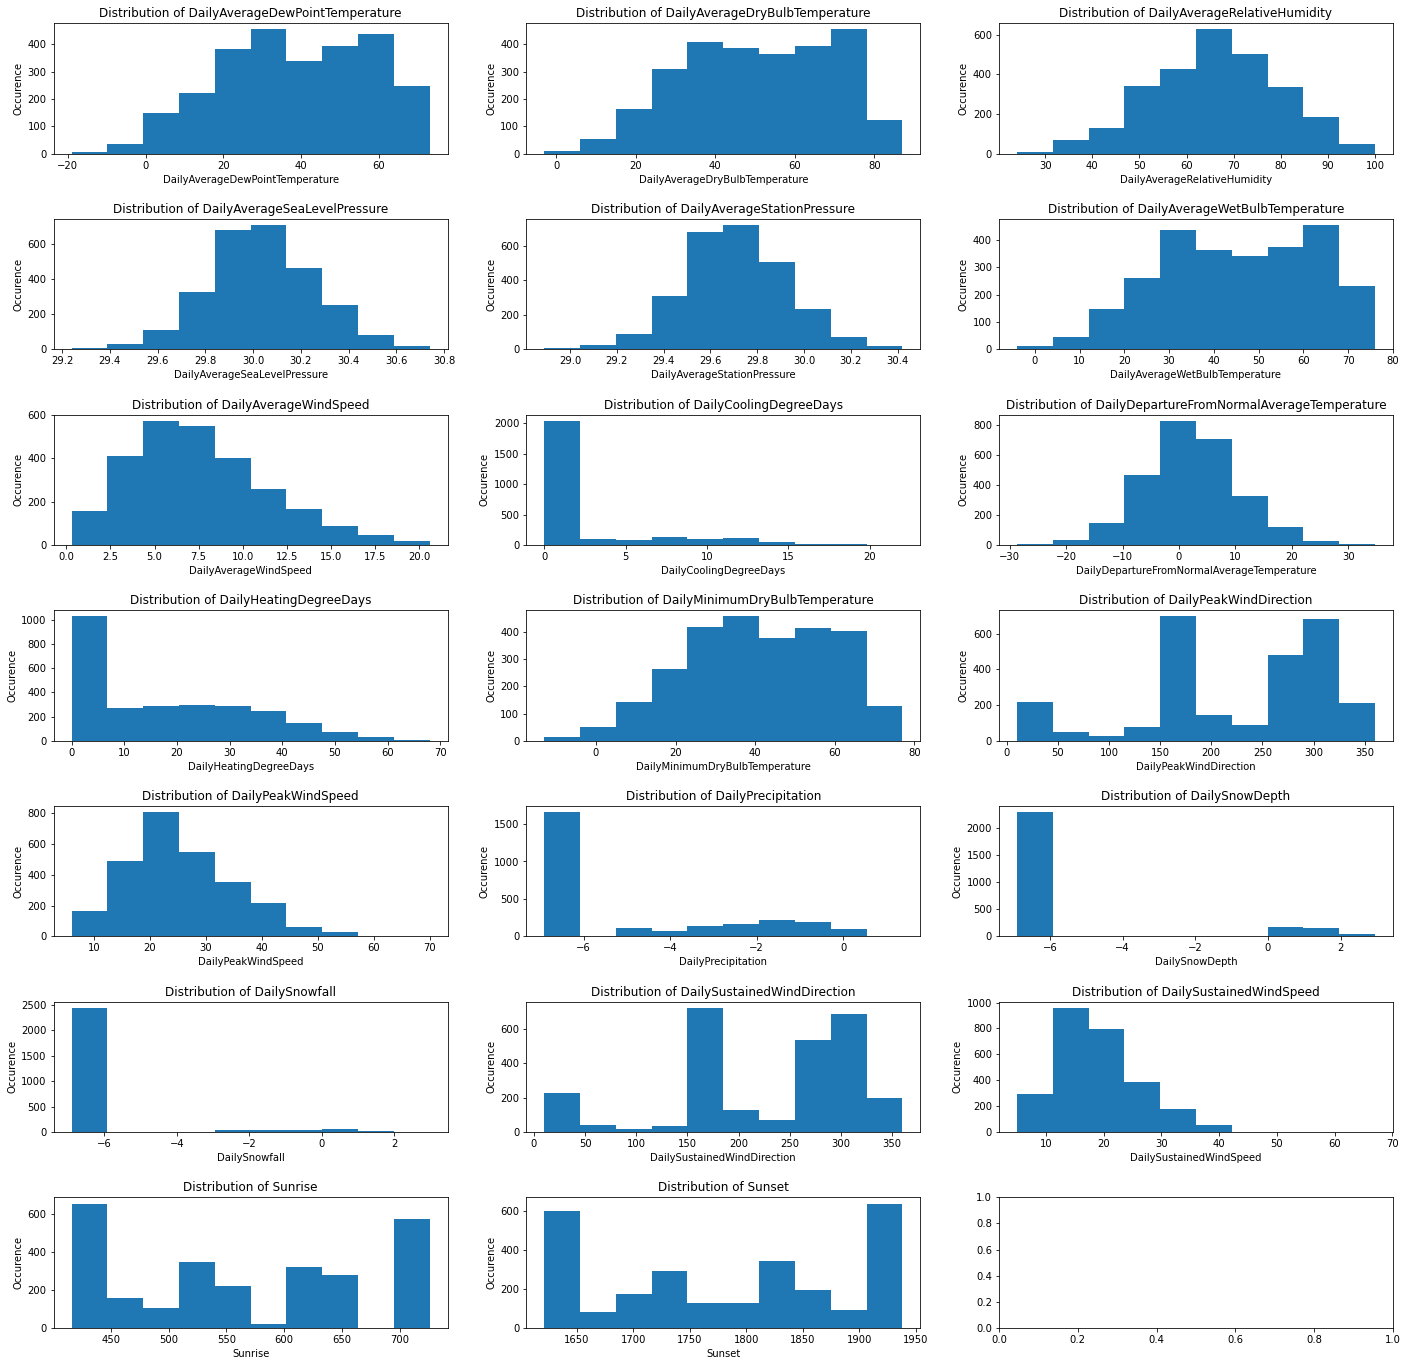

In [8]:
fig, axs = plt.subplots(7, 3, figsize=(24, 24))
for cidx, c in enumerate(X.columns):
    row_idx = cidx // 3
    col_idx = cidx % 3
    ax = axs[row_idx][col_idx]
    data = X[c]
    ax.hist(data)
    ax.set_title(f"Distribution of {c}")
    ax.set_xlabel(c)
    ax.set_ylabel('Occurence')
plt.subplots_adjust(hspace=0.5)
plt.show()

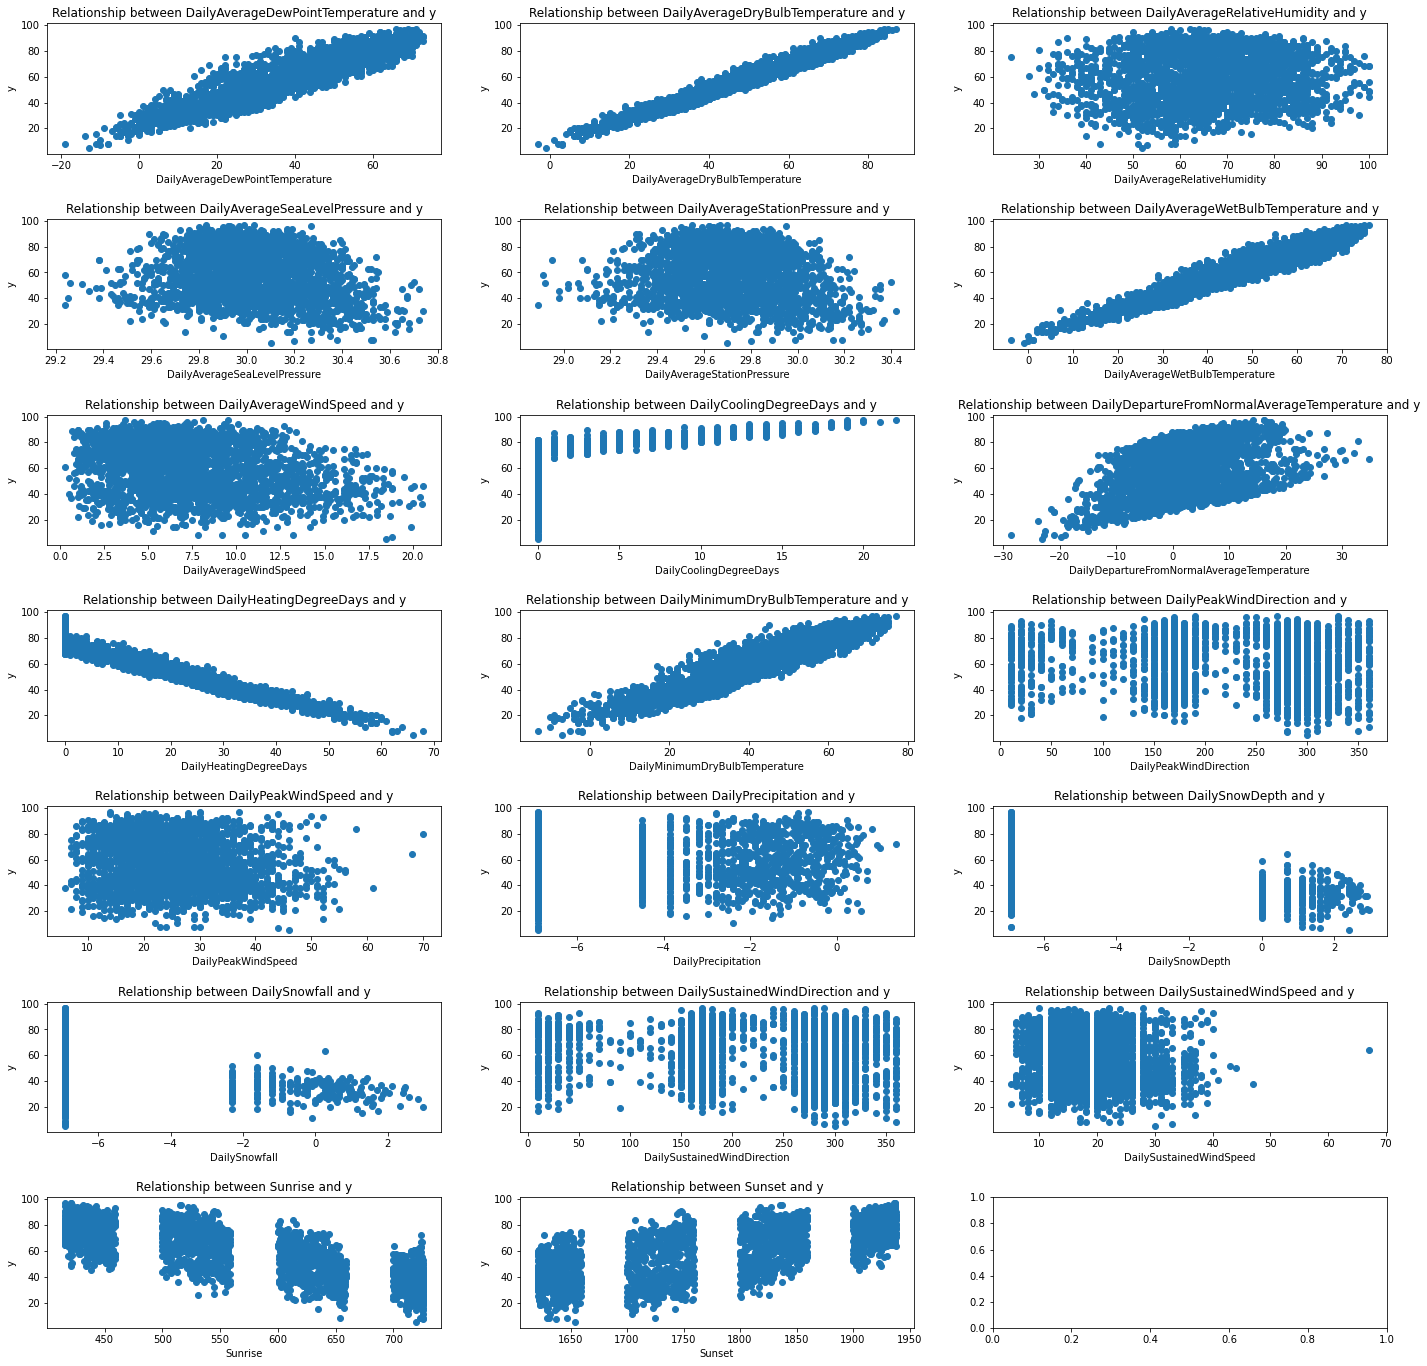

In [9]:
fig, axs = plt.subplots(7, 3, figsize=(24, 24))
for cidx, c in enumerate(X.columns):
    row_idx = cidx // 3
    col_idx = cidx % 3
    ax = axs[row_idx][col_idx]
    data = X[c]
    ax.scatter(data, y)
    ax.set_title(f"Relationship between {c} and y")
    ax.set_xlabel(c)
    ax.set_ylabel('y')
plt.subplots_adjust(hspace=0.5)
plt.show()

## Normalization
For Decision Trees and Random Forests the variance of the features did not matter. However, this is not true for GLMs when we use Gradient Descent-like methods to optimize these models. The reason for this is that the loss-function's value as well as the gradient-values of the loss function heavily depend on the scale of the features. The effect of this is that if we have a feature with a small variance and a feature with a high variance, the GD algorithm will favor the high-variance features and "ignore" the low-variance features since these do not contribute much to the minimization process when the parameters are updated.

Thus we will normalize all features independently s.t. they have a variance of 1 and a mean of 0. This normalization is also known as standardization.

> **NOTE** It's important to find the scaling parameters using the training-data only since the test-data represents future data (i.e. we assume to not know a prioir). Thus finding scaling parameters using the entire dataset would introduce future information about unseen data. This should of course not be the case

In [10]:
# split data into train- and test-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))

> **Task**
> 
> Think about why scaling all variables to the same interval is important for Gradient based methods.

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
y_hat = lr.predict(X_test)
r2 = r2_score(y_test, y_hat)
r2

0.9993845300984239

In [14]:
lr.coef_

array([[-3.07200943e-03,  7.97273555e-01, -7.07453146e-03,
         5.96428789e-03, -5.92480517e-03,  5.60176915e-02,
        -4.30636434e-03,  2.23993063e-01, -3.32904396e-04,
        -8.66932263e-01, -8.87295766e-01,  5.19814804e-04,
         2.58032498e-03, -1.36138773e-03, -3.89433039e-04,
         6.71162934e-04, -4.84350135e-04,  1.18386801e-03,
        -5.01455486e-03, -2.83225992e-03]])

In order to rate how good our regression model performs, we use the $R^2$-score which is defined as follows:
\begin{equation}
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i(y_i - \bar{y})^2}
\end{equation}
Here, $\hat{y}_i$ is the prediction of our model for datapoint $i$ and $\bar{y} = \frac{1}{n} \sum_i y_i$ is the mean of our response variable. The $R^2$-score thus measures how much of the variance of $y$ is explained by our model. If we replace our model by $\bar{y}$ (which can be seen as a baseline model), we obtain $R^2 = 0$, if our model is able to reduce the error (and thus its variance) to 0, we will obtain $R^2 = 1$. 

Our model is working well, achieving $R^2 = 0.99$. However, we can see that there are many coefficients in our model that have very low values (e.g. $-1.03\times 10^{-4}$). This indicates that there is not a strong relationship between these variables and the target variable. This is not surprising if we look at our scatter-plots from above: There are some variables that seem to be independent of $y$, thus provide no information to predict $y$.

In order to reduce our model complexity (and with this reducing the risk of overfitting), we should remove some of the features from our data. Obviously we should remove those not carrying much information about the variable we aim to predict. We could do this either manually by checking the correlation between each feature and $y$ separartely and decide if we keep the feature based on some threshold, or we can employ automatic methods. One approach would be to use PCA. PCA is a dimensionality-reduction algorithm aiming to extract the most informative features.

> **IMPORTANT!** Be careful when using PCA! This algorithm works well in linear cases, but in non-linear cases this method might yield unsatisfying results.

Another possible way to remove features from the data is to integrate feature selection directly into the model we fit. The most famous method to achieve this is called Lasso and adds a regularization constraint to the ordinary least square-loss:
\begin{equation}
L_{\mathbf{w}}(\mathbf{X}, \mathbf{y}) = \frac{1}{n} \sum_{i=1}^n (\mathbf{y}_i - \mathbf{w}\mathbf{X})^2 + \lambda||\mathbf{w}||_1
\end{equation}
There are two well-known interpretations of this last term: The first interpretation states that we "move our loss up for higher weights". This means that SGD will favor lower weights over higher weights, possibly resulting in "turning off" some of the feature that do not provide useful information (i.e. correlation 0).

A second interpretation takes a Lagrangian viewpoint on this: We can view $\lambda ||\mathbf{w}||_1$ as a Lagrangian multiplier, thus imposing a constraint $||\mathbf{w}||_1 - c \leq 0$ for some constant $c$. In other words we force our weights to be in a feasible region consisting of weights with an $L^1$-norm lower or equal to $c$. Thus the optimization problem gets:
\begin{gather}
& L_{\mathbf{w}}(\mathbf{X}, \mathbf{y}) = \frac{1}{n} \sum_{i=1}^n (\mathbf{y}_i - (\mathbf{w}\mathbf{X})^T_i)^2  \\
s.t. & ||\mathbf{w}||_1 - c \leq 0
\end{gather}
Since the Lagrangian method is not capable of handling inequality-constraints, we add a slack variable and obtain:
\begin{equation}
||\mathbf{w}||_1 - c + s^2 = 0
\end{equation}
Building the Lagrangian yields:
\begin{equation}
\mathcal{L}_{\mathbf{w}}(\mathbf{X}, \mathbf{y}) = \frac{1}{n} \sum_{i=1}^n (\mathbf{y}_i - (\mathbf{w}\mathbf{X})^T_i)^2 + \lambda ||\mathbf{w}||_1 - \lambda c + \lambda s^2
\end{equation}
The Lagrangian has a solution iff $\nabla_{\mathbf{w}, \lambda}\mathcal{L} = 0$, i.e. if $\nabla_{\mathbf{w}}L = \lambda \nabla_{\mathbf{w}}||\mathbf{w}||_1$ and the constraint is fulfilled, i.e. $\lambda ||\mathbf{w}||_1 - c + s^2 = 0$. Since $c$ and $s^2$ are constants, they do not affect the solution of the gradients.
It can be shown that on optimal solutions $\mathbf{w}^*$ for $\mathcal{L}$, either $\lambda = 0$ holds or the slack variables are 0, thus we can ignore $s^2$.
This yields
\begin{equation}
\mathcal{L}_{\mathbf{w}}(\mathbf{X}, \mathbf{y}) = \frac{1}{n} \sum_{i=1}^n (\mathbf{y}_i - (\mathbf{w}\mathbf{X})^T_i)^2 + \lambda ||\mathbf{w}||_1 - \lambda c
\end{equation}
Now $\mathcal{L}$ and $L$ are almost identical, except for the $\lambda c$ in $\mathcal{L}$. It can be shown that $L$ and $\mathcal{L}$ have the same solution iff $c = \mathbf{w}_L^*(\lambda)$, where we emphasize that $\mathbf{w}_L^*(\lambda)$ is a solution optimizing $L$ for a given $\lambda$. This in turn means that we can also ignore $c$ in $\mathcal{L}$ since we can control the set of feasible solutions using $\lambda$. Intuitively this makes sense since for smaller $\lambda$ the penalty of choosing bigger weights is less and vice versa.

> **NOTE** In general we can add an $L^p$-norm to the loss to reguralize our model. For each $p \in \mathbb{N}$ this regularization would have different effects. For example picking $p = 2$ does not lead to sparser models, but to smaller weights.

Now let's train a model using Lasso and see what happens.

In [15]:
lr = Lasso(0.05)
lr.fit(X_train, y_train)

Lasso(alpha=0.05)

In [16]:
y_hat = lr.predict(X_test)
r2 = r2_score(y_test, y_hat)
r2

0.9686209921289941

In [17]:
lr.coef_

array([ 0.        ,  0.89664746, -0.02077403,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.04254444,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ])

In [18]:
coefs = np.argwhere(lr.coef_ != 0)
coefs

array([[1],
       [2],
       [9]])

In [22]:
print(data.columns[1])
print(data.columns[2])
print(data.columns[9])

DailyAverageDryBulbTemperature
DailyAverageRelativeHumidity
DailyHeatingDegreeDays


We obtain that we still get a good $R^2$-score, however our model only uses 3 variables instead of all 20. But what is special about the $L^1$-norm producing sparse models (which is not the case for e.g. the $L^2$-norm). Intuitively, the $L^1$-norm is a linear function of the weight everywhere except for 0 while the $L^2$-norm is a quadratic function of the weights. The derivative of a linear function is a constant, which means that, when updating the weights, we make the weights smaller by exactly a value of $\lambda$. For the $L^2$-norm this is not the case and the derivatives get smaller the nearer our weights get to 0. This means we keep taking smaller and smaller steps, never reaching 0.

Another interpretation comes from analysis: Note that the $L^1$-norm is not differentiable at the point 0, thus we can use infinetly many tangents "approximating" the "derivative" (which of course isn't defined). Since we are dealing with a convex optimization problem, our solution will be found on a line where our condition $||\mathbf{w}||_1 - c = 0$ holds. Since there are infintely many tangents that are valid approximations of the $L^1$-"derivative" at points where some $w_i = 0$, we have many possible solutions to our constrained optimization problem because we will find a tangent that touches our constraint and the loss. Considering the $L^2$-norm, such an event is much more inlikely because a quadratic function is differentiable at any point. Thus for points with some $w_i=0$ only shres one tangent with the loss.

These two intuitions explain why the $L^1$-norm favours sparser models than the $L^2$-norm.

## Classification
GLMs cannot only be used to perform regressions, but we can also solve classification tasks with them. The only thing we need to transform an ordinary linear regression into a classification-model is the logistic function. This is defined as $\sigma(x) = \frac{1}{1 - e^x}$ and is also known as the sigmoid function. In this case our target variable is a Bernoulli-variable, i.e. it can only take the value 0 or 1.

Let's see our data and check if it is appropriate to use such a classifier.

In [11]:
# load data
data = pd.read_csv('../data/credit-data/prepared_data.csv', index_col=0)

# extract labels
y = data['Credit_Score'].to_numpy()
X = data.drop(columns=['Credit_Score']).to_numpy()

In [45]:
np.unique(y)

array([0, 1, 2])

We see that we three classes in our target variable. Unfortunately that's bad news for our logistic model since it is only capable of discriminating 2 values. What can we do about this? Either we declare two of our classes as one new class (e.g. 1 + 2 being class 1). Alternatively we can train two logistic regressions, one discriminating among 1 and 0, the other one discriminating between 1 and 2. But the second approach brings some drawbacks: Since these two models don't know about each other, what would we do if $m_1$ (the model discriminating 0 and 1) predicts a 1 with a probability of 0.75 and $m_2$ (the model discriminating between 1 and 2) predicts 2 with a probability of 0.7? Of course we could simply pick the one with the higher probability, however this wouldn't give us any guarantees regarding our minimization problem. In other words: Since our models only know a subset of all classes, they have to try to assign a label of these subclasses to each input. Thus, we can't trust $m_1$ if we have a class 2 input and we can't trust $m_2$ if we have a class 0 input. This means if $m_1$ and $m_2$ give contradictionary results, we can't tell the classes apart from each other because the classes "share" a subset, rendering them indistinguishable.

Another possibility is to extend the model to train a model with three outputs. This accounts for the flaws with the former approach because now our model knows all three classes and we don't have to artificially build "mixed subspaces". This way our model is able to learn to tell the classes apart.

We will choose the first approach since the last approach requires us to introduce some more math which is postponed to the next section about Neural Networks. Then we will try exactly the approach with a model having multiple outputs.

But first things first: Let's start and check if we have to do any further preprocessing except for grouping class 1 and 2 together:

> **Task**
> 
> What would we have to do if we face a multi-class classification-task?

In [46]:
y[y == 2] = 1

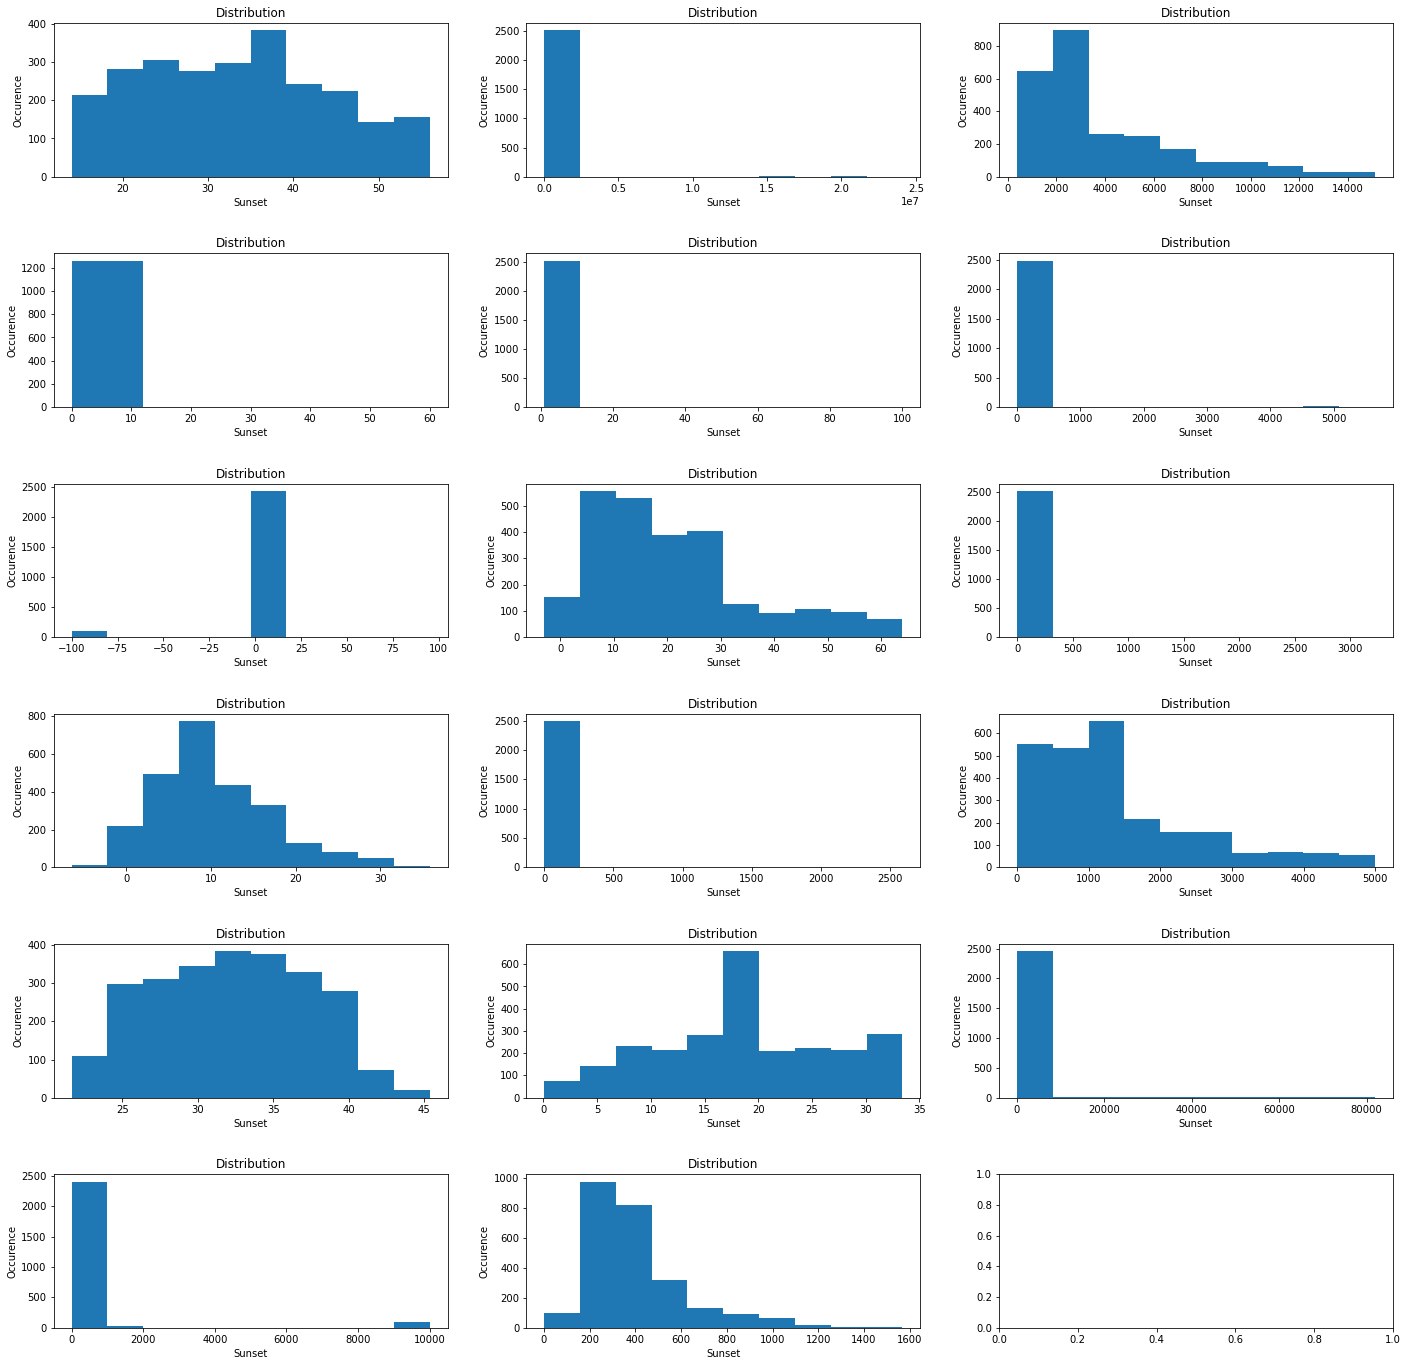

In [47]:
fig, axs = plt.subplots(6, 3, figsize=(24, 24))
for cidx in range(X.shape[1]):
    row_idx = cidx // 3
    col_idx = cidx % 3
    ax = axs[row_idx][col_idx]
    data = X[:, cidx]
    ax.hist(data)
    ax.set_title(f"Distribution")
    ax.set_xlabel(c)
    ax.set_ylabel('Occurence')
plt.subplots_adjust(hspace=0.5)
plt.show()

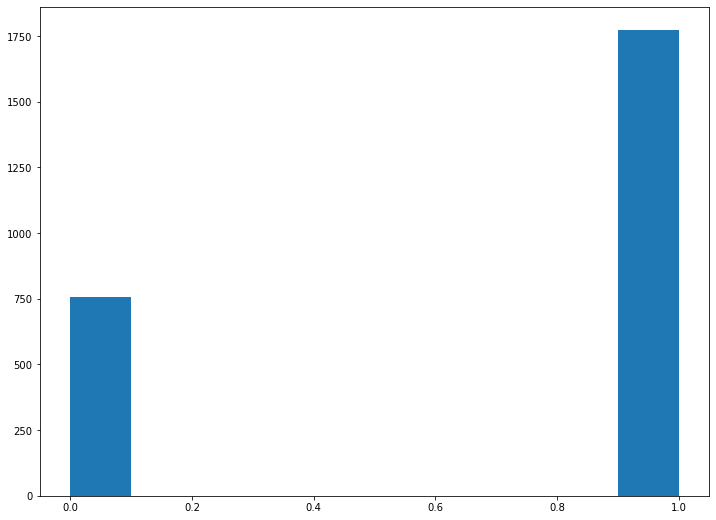

In [48]:
fig = plt.figure(figsize=(12, 9))
plt.hist(y)
plt.show()

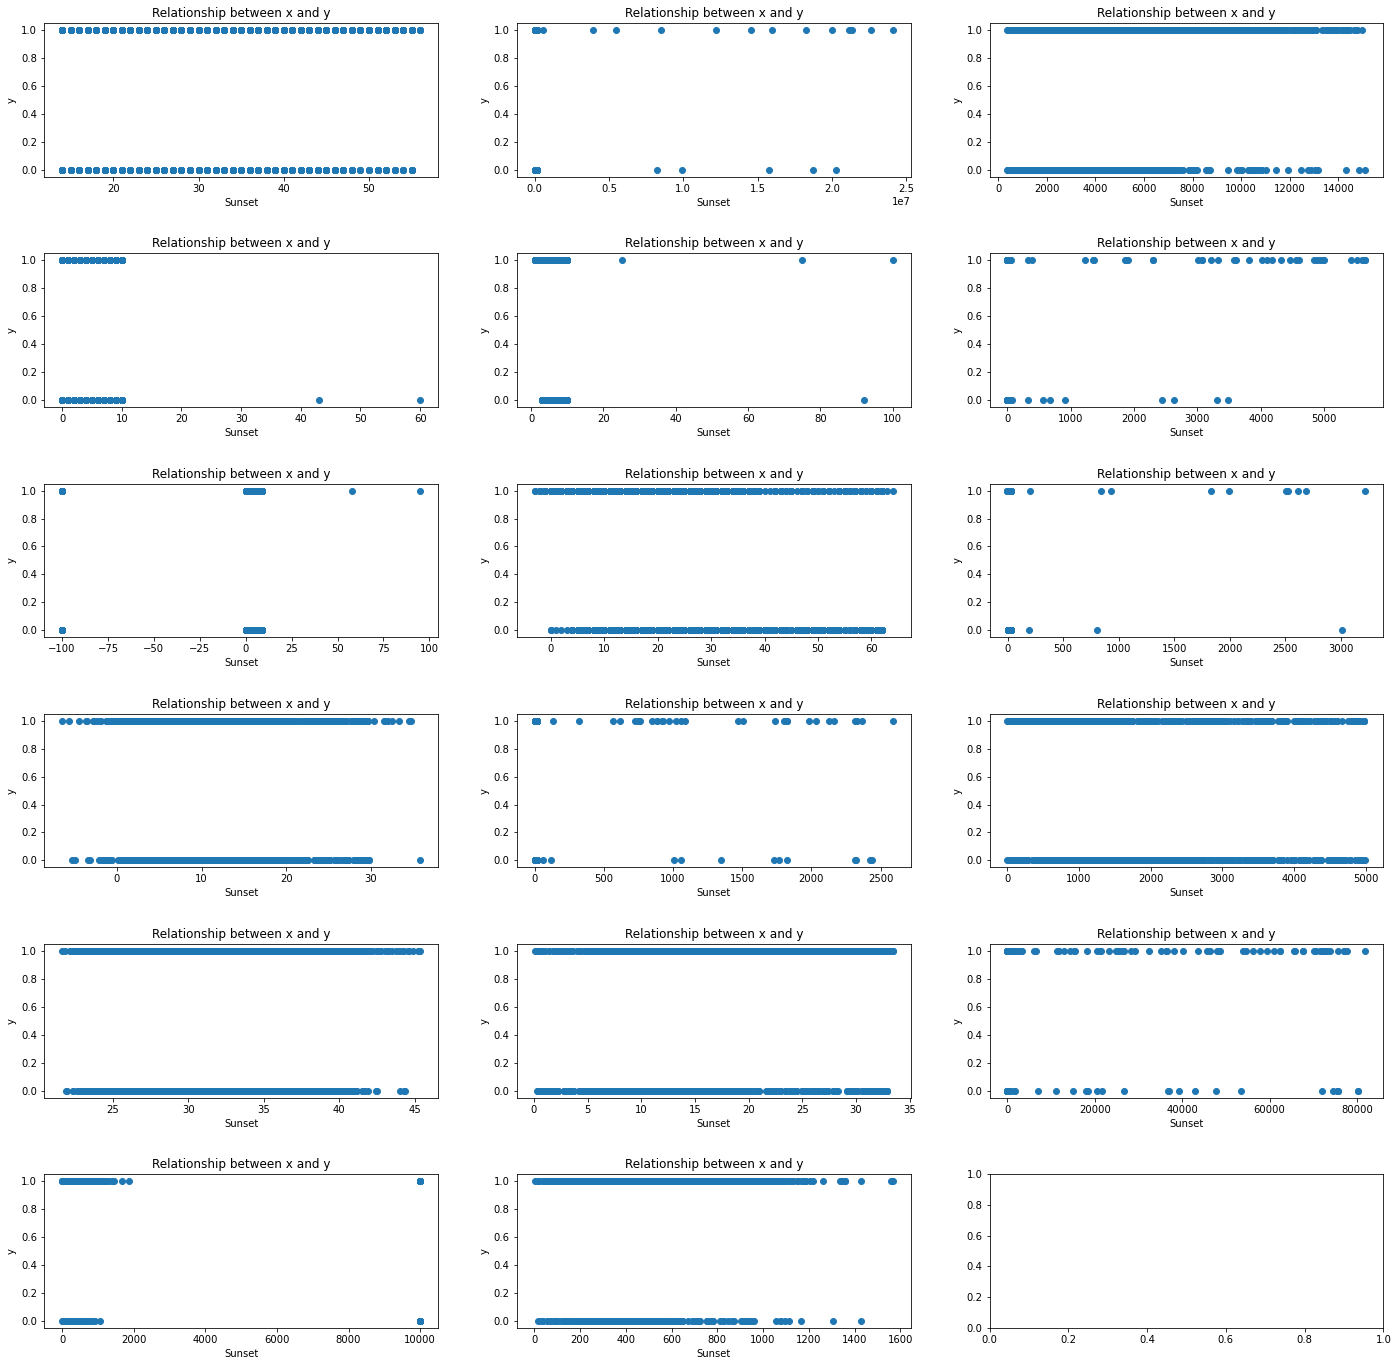

In [49]:
fig, axs = plt.subplots(6, 3, figsize=(24, 24))
for cidx in range(X.shape[1]):
    row_idx = cidx // 3
    col_idx = cidx % 3
    ax = axs[row_idx][col_idx]
    data = X[:, cidx]
    ax.scatter(data, y)
    ax.set_title(f"Relationship between x and y")
    ax.set_xlabel(c)
    ax.set_ylabel('y')
plt.subplots_adjust(hspace=0.5)
plt.show()

We can see a few things from this:
1. We have imbalanced classes (which makes sense since we have defined class 2 as being class 1)
2. We have 2 feature that are hevaily skewed or are non-normal. We don't necessarily have to change this, but maybe it's beneficial

So let's start with 1.: What are the effect of imbalanced classes and how can we handle this?


In [81]:
# split data into train- and test-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

In [92]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [93]:
y_hat = lr.predict(X_test)
acc = accuracy_score(y_hat, y_test)
acc

0.7575757575757576

In [94]:
f1 = f1_score(y_hat, y_test)
f1

0.8402777777777778

In [95]:
tp = y_test[(y_test == 1) & (y_hat == 1)]
fp = y_test[(y_test == 0) & (y_hat == 1)]
tn = y_test[(y_test == 0) & (y_hat == 0)]
fn = y_test[(y_test == 1) & (y_hat == 0)]

<AxesSubplot:>

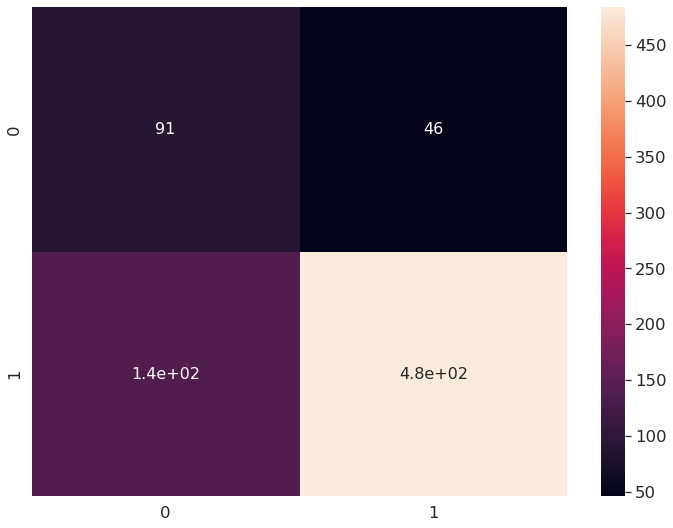

In [96]:
df = pd.DataFrame(data=[[len(tn), len(fn)], [len(fp), len(tp)]])
fig = plt.figure(figsize=(12, 9))
sns.set(font_scale=1.5)
sns.heatmap(df, annot=True, annot_kws={"size": 16})

Let's see if we can do better with setting class weights

In [118]:
lr_weighted = LogisticRegression(class_weight='balanced')
lr_weighted.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [119]:
y_hat_weighted = lr_weighted.predict(X_test)
acc = accuracy_score(y_hat, y_test)
acc

0.7523056653491436

In [120]:
f1 = f1_score(y_hat_weighted, y_test)
f1

0.8171206225680935

In [121]:
tp = y_test[(y_test == 1) & (y_hat_weighted == 1)]
fp = y_test[(y_test == 0) & (y_hat_weighted == 1)]
tn = y_test[(y_test == 0) & (y_hat_weighted == 0)]
fn = y_test[(y_test == 1) & (y_hat_weighted == 0)]

<AxesSubplot:>

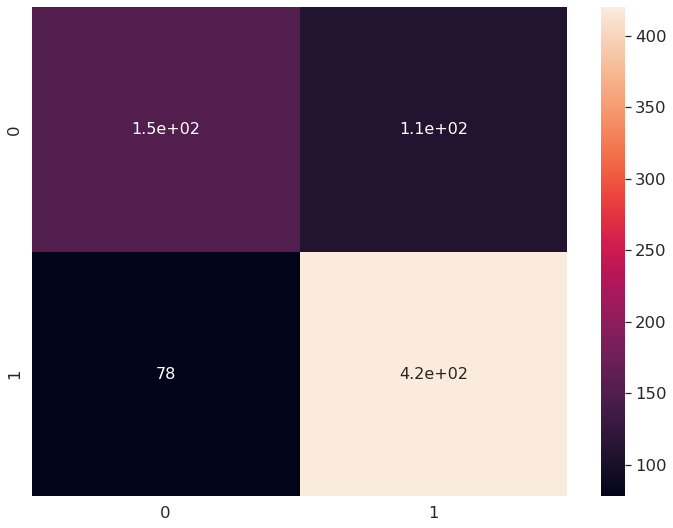

In [122]:
df = pd.DataFrame(data=[[len(tn), len(fn)], [len(fp), len(tp)]])
fig = plt.figure(figsize=(12, 9))
sns.set(font_scale=1.5)
sns.heatmap(df, annot=True, annot_kws={"size": 16})

We see that in this case the data imbalance is not a big problem, we even get worse if we add the weighting of the classes. Even more interesting is the observation that without class weighting, we have many false negative predictions while with class weights we see many fals positive predictions. This is an indicator that we either picked the wrong class weights or we set our thresholding value wrongly. Let's investigate this!

In [109]:
y_hat_proba = lr.predict_proba(X_test)
y_hat_proba_weighted = lr_weighted.predict_proba(X_test)
rc_fp, rc_tp, rc_thres = roc_curve(y_test, y_hat_proba[:, 1])
rc_weighted_fp, rc_weighted_tp, rc_weighted_thres = roc_curve(y_test, y_hat_proba_weighted[:, 1])

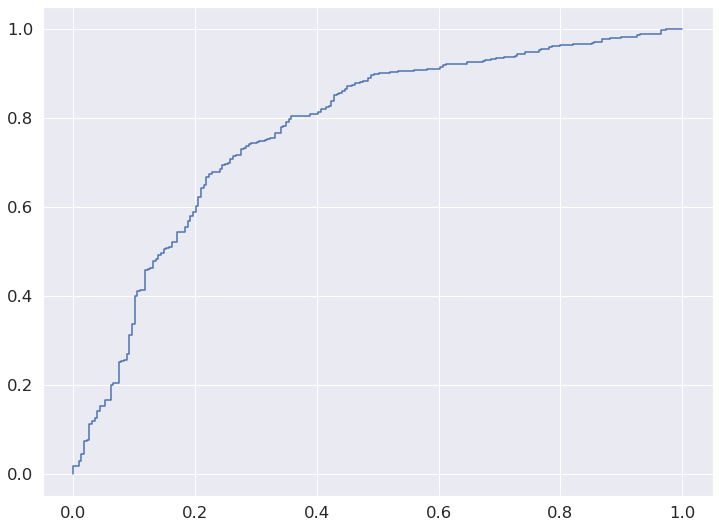

In [110]:
fig = plt.figure(figsize=(12, 9))
plt.plot(rc_fp, rc_tp)

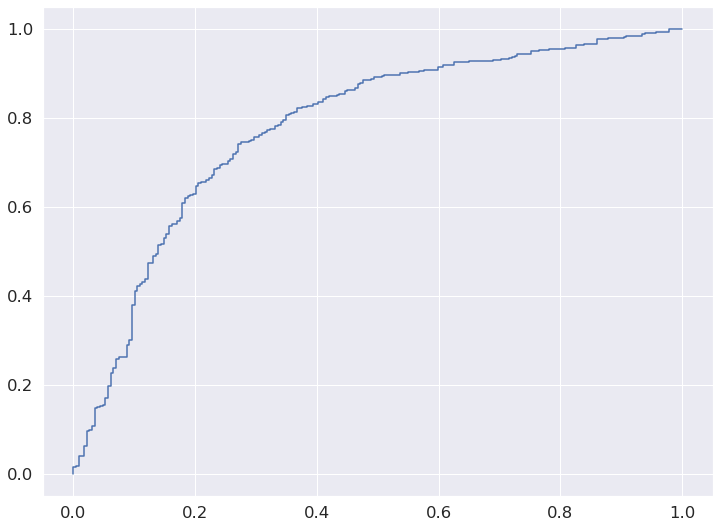

In [111]:
fig = plt.figure(figsize=(12, 9))
plt.plot(rc_weighted_fp, rc_weighted_tp)

In [114]:
optimal_thres_idx = np.argmax(rc_tp - rc_fp)
optimal_thres_weighted_idx = np.argmax(rc_weighted_tp - rc_weighted_fp)

In [115]:
optimal_thres = rc_thres[optimal_thres_idx]
optimal_thres_weighted = rc_weighted_fp[optimal_thres_weighted_idx]

In [116]:
optimal_thres

0.7411101374848111

In [117]:
optimal_thres_weighted

0.27510917030567683

Let's see the accuracy and f1-scores if we pick the respective decision cut-offs.

In [125]:
pred = np.ones(len(y_hat))
pred_weighed = np.ones(len(y_hat_weighted))
negative = np.argwhere(y_hat_proba[:, 1] < optimal_thres)
negative_weighted = np.argwhere(y_hat_proba_weighted[:, 1] < optimal_thres_weighted)
pred[negative] = 0
pred_weighed[negative_weighted] = 0

In [126]:
acc, acc_weighted = accuracy_score(pred, y_test), accuracy_score(pred_weighed, y_test)
acc

0.7285902503293807

In [127]:
acc_weighted

0.7602108036890646

In [128]:
f1, f1_weighted = f1_score(pred, y_test), f1_score(pred_weighed, y_test)
f1

0.7897959183673469

In [129]:
f1_weighted

0.842560553633218

Now we see the effect of weighting the classes. The weighted version outperforms the standard classifier without class weighting. 

In [130]:
tp = y_test[(y_test == 1) & (pred == 1)]
fp = y_test[(y_test == 0) & (pred == 1)]
tn = y_test[(y_test == 0) & (pred == 0)]
fn = y_test[(y_test == 1) & (pred == 0)]

tp_weighted = y_test[(y_test == 1) & (pred_weighed == 1)]
fp_weighted = y_test[(y_test == 0) & (pred_weighed == 1)]
tn_weighted = y_test[(y_test == 0) & (pred_weighed == 0)]
fn_weighted = y_test[(y_test == 1) & (pred_weighed == 0)]

<AxesSubplot:>

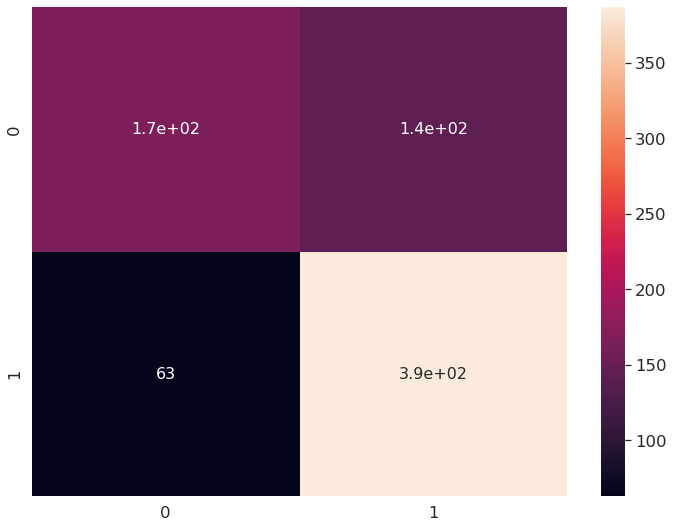

In [131]:
df = pd.DataFrame(data=[[len(tn), len(fn)], [len(fp), len(tp)]])
fig = plt.figure(figsize=(12, 9))
sns.set(font_scale=1.5)
sns.heatmap(df, annot=True, annot_kws={"size": 16})

<AxesSubplot:>

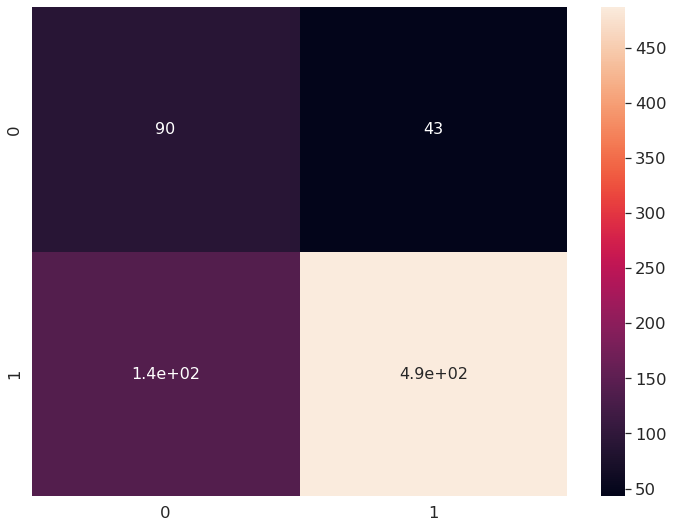

In [132]:
df = pd.DataFrame(data=[[len(tn_weighted), len(fn_weighted)], [len(fp_weighted), len(tp_weighted)]])
fig = plt.figure(figsize=(12, 9))
sns.set(font_scale=1.5)
sns.heatmap(df, annot=True, annot_kws={"size": 16})